In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from ast import literal_eval
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import warnings
warnings.filterwarnings("ignore")
from sklearn.decomposition import TruncatedSVD
from scipy.sparse.linalg import svds

In [38]:
# reading csv file created and exception handling
try:
    df = pd.read_csv('final_ITEM_DATA1.csv')
    df = df.dropna(subset=['Name'])
    df = df.dropna(subset=['AppID'])
    
    data = pd.read_csv('user_data.csv')
    new_column_names = {'gameName':'Name'}
    data.rename(columns=new_column_names, inplace=True)
    
    print("===================== item data Dataset ===================== ")
    print(df)
    
    print("===================== user data Dataset ===================== ")
    print(data)
    
    

    item_row = df[df['AppID'] == 1139950]
    
    # Print the rows for APPID 1139950
    print("========================== APPID 139950 ========================== ")
    print(item_row)

except FileNotFoundError as e:
    print("Error: Cannot find the File(CSV), Check the Path again")
    exit(1)
    
print("===================== data frame shape ===================== ")   
print("game data shape:")
print(df.shape)
print("user data shape:")
print(data.shape)

===================== item data Dataset ===================== 
         AppID  Cluster_Labels                    Name  Release date  \
0        20200               0        Galactic Bowling          3775   
1       655370               0            Train Bandit          3656   
2      1732930               0            Jolt Project          3364   
3      1355720               0                Henosis™          1955   
4      1139950               0   Two Weeks in Painland          1357   
...        ...             ...                     ...           ...   
76982  1619420               0                Diebrary           377   
76983  2224030               0            Flutter Away           658   
76984  2503930               0  Surreal House Playtest           377   
76985  2524860               0         Spot the Object           694   
76986  2431960               0     擱淺地 - Dream Antique           508   

       Estimated owners  Peak CCU  Required age     Price  DLC count  \


[ 258.64597686   44.87758839 -305.55347667  144.01168696 -110.49111542
    1.57386067  -30.90133091  115.07516457   12.407999    370.74311921
   26.48069058 -299.43331317]


<AxesSubplot:>

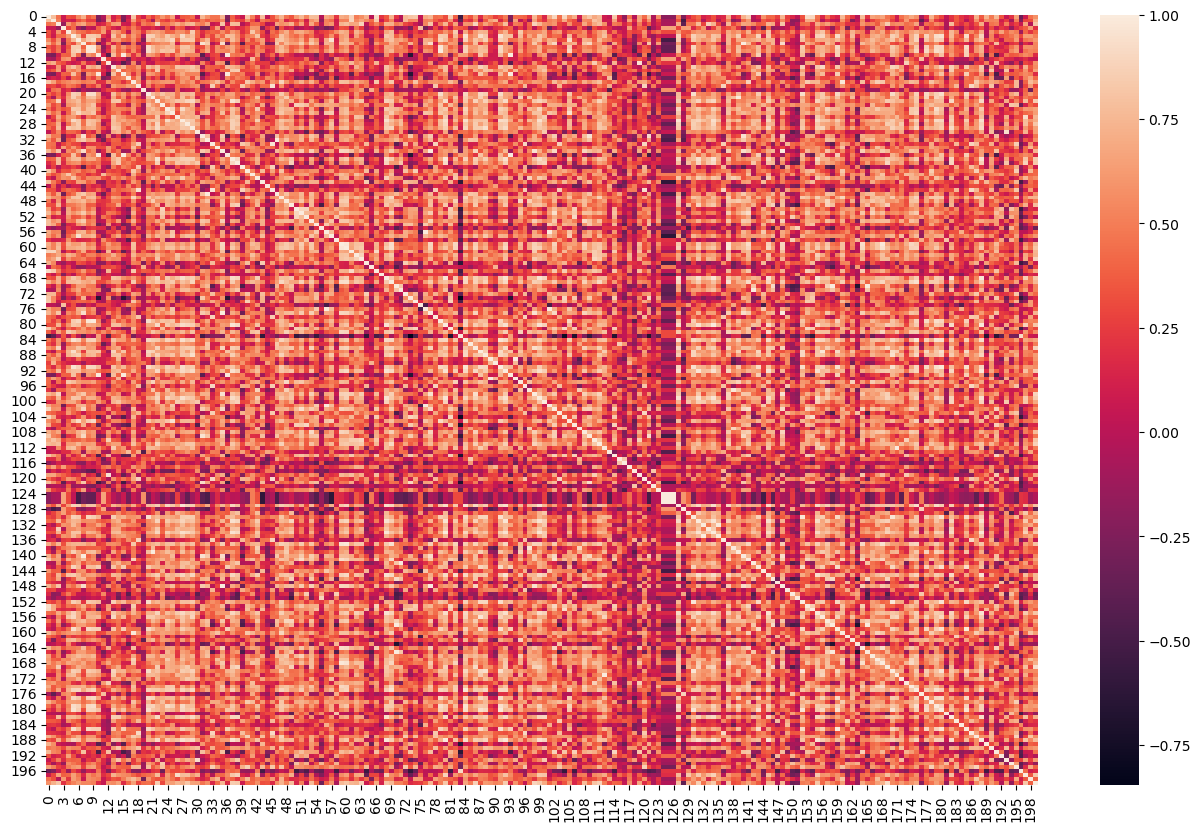

In [39]:
# Item data and game data are combined using a merge function.
user_item_data = pd.merge(data, df, on = 'Name')

# Create a pivot table and put a value at the beginning, 
# and put the game name in the column and the userid in the index.

# We set it as 'Release date' as an example of value.
user_item_Release_date = user_item_data.pivot_table('Release date', index = 'userId', columns='Name').fillna(0)

item_user_Release_date = user_item_Release_date.values.T

type(item_user_Release_date)

# Specific value decomposition SVD is used to decompose the data.
# ttruncated SVD is the selection of the top n diagonal elements of the sigma matrix.

# 1Dimension down to 12 components
SVD = TruncatedSVD(n_components=12)
matrix = SVD.fit_transform(item_user_Release_date)

print(matrix[0])

# Find Pearson correlation coefficients
corr = np.corrcoef(matrix)

corr2 = corr[:200, :200]

# Display as a heat map
plt.figure(figsize=(16, 10))
sns.heatmap(corr2)



In [40]:
# Recommend a movie with a high correlation coefficient with a particular movie
item_title = user_item_Release_date.columns
item_title_list = list(item_title)
coffey_hands = item_title_list.index("Fallout 4")

In [26]:
# Indicates a game with a high correlation coefficient with a particular game.
corr_coffey_hands  = corr[coffey_hands]
list(item_title[(corr_coffey_hands >= 0.9)])[:50]

['0RBITALIS',
 'ArcaniA',
 'Banished',
 'Battlestations Pacific',
 'Bound By Flame',
 'Car Mechanic Simulator 2014',
 'Company of Heroes 2',
 'DayZ',
 'DiRT Rally',
 'Dying Light',
 'Elite Dangerous',
 'Euro Truck Simulator 2',
 'Fallout 4',
 'Far Cry 3',
 'Game Dev Tycoon',
 'Grand Theft Auto V',
 'Hack, Slash, Loot',
 'Homeworld Remastered Collection',
 'Kerbal Space Program',
 'Legend of Grimrock 2',
 'Mad Max',
 'Metro 2033 Redux',
 'Peggle Extreme',
 'Planetbase',
 'Prison Architect',
 'Project CARS',
 'RAGE',
 'Rebel Galaxy',
 'Remember Me',
 'Rodina',
 'Savage Lands',
 'Shift 2 Unleashed',
 "Sid Meier's Pirates!",
 'Sniper Elite 3',
 'Star Trek Online',
 'State of Decay',
 'Stranded Deep',
 'Take On Helicopters',
 'Take On Mars',
 'Thief',
 'Tomb Raider',
 'Tropico 5',
 'Way of the Samurai 4',
 'X Rebirth']

In [41]:
def evaluate_recommender_recall_f1(user_item_matrix, original_ratings, top_n=10, threshold=0.9):
 
    num_users, num_items = user_item_matrix.shape
    true_positive = 0  # Number of correctly recommended items that the user likes
    all_recommended = 0  # Number of items recommended by the system
    actual_liked = 0  # Number of items that the user actually likes

    for user_index in range(num_users):
        # Get the indices of the top-n items recommended by the system
        top_n_indices = np.argsort(user_item_matrix[user_index, :])[-top_n:]

        # Get the items the user has actually interacted with
        actual_items = original_ratings.iloc[user_index, :].values.nonzero()[0]

        # Calculate the number of correctly recommended items
        correct_recommendations = np.intersect1d(top_n_indices, actual_items)
        true_positive += len(correct_recommendations)

        # Update the number of all recommended items
        all_recommended += len(top_n_indices)

        # Update the number of items that the user actually likes
        actual_liked += len(actual_items)

    # Calculate recall
    recall = true_positive / actual_liked if actual_liked > 0 else 0.0

    # Calculate precision
    precision = true_positive / all_recommended if all_recommended > 0 else 0.0

    # Calculate F1-score
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0.0

    return recall, f1_score

# Example usage:
recall, f1_score = evaluate_recommender_recall_f1(matrix, user_item_Release_date)
print(f'Recall: {recall}, F1-score: {f1_score}')

Recall: 0.0008746173549072281, F1-score: 0.0008324166840086809


===================== item data Dataset ===================== 
         AppID  Cluster_Labels                    Name  Release date  \
0        20200               0        Galactic Bowling          3775   
1       655370               0            Train Bandit          3656   
2      1732930               0            Jolt Project          3364   
3      1355720               0                Henosis™          1955   
4      1139950               0   Two Weeks in Painland          1357   
...        ...             ...                     ...           ...   
76982  1619420               0                Diebrary           377   
76983  2224030               0            Flutter Away           658   
76984  2503930               0  Surreal House Playtest           377   
76985  2524860               0         Spot the Object           694   
76986  2431960               0     擱淺地 - Dream Antique           508   

       Estimated owners  Peak CCU  Required age     Price  DLC count  \


['Air Brawl',
 'Alan Wake',
 "Alan Wake's American Nightmare",
 'ArcaniA',
 'Arma 3',
 'Banished',
 'Besiege',
 'BioShock Infinite',
 'Black Mirror',
 'Borderlands 2',
 'Brothers - A Tale of Two Sons',
 'Company of Heroes',
 'Company of Heroes 2',
 'Contagion',
 'Crusader Kings II',
 'DRAGON BALL XENOVERSE',
 'DayZ',
 'Deadlight',
 'Democracy 3',
 'Depth',
 'Dishonored',
 "Don't Starve",
 'Dying Light',
 'Euro Truck Simulator 2',
 'F.E.A.R.',
 'Fable Anniversary',
 'Fallout 4',
 'Far Cry 3',
 'Final DOOM',
 'GRID',
 'Game Dev Tycoon',
 'Game of Thrones - A Telltale Games Series',
 'Grand Theft Auto V',
 'Grow Home',
 'Guns of Icarus Online',
 "Hack 'n' Slash",
 'Hack, Slash, Loot',
 'Homefront',
 'Homeworld Remastered Collection',
 'Hotline Miami',
 'How to Survive',
 'Infested Planet',
 'Insurgency',
 'Interstellar Marines',
 'Just Cause 2',
 'Kerbal Space Program',
 "King Arthur's Gold",
 'L.A. Noire',
 'Legend of Grimrock 2',
 'Lunar Flight']

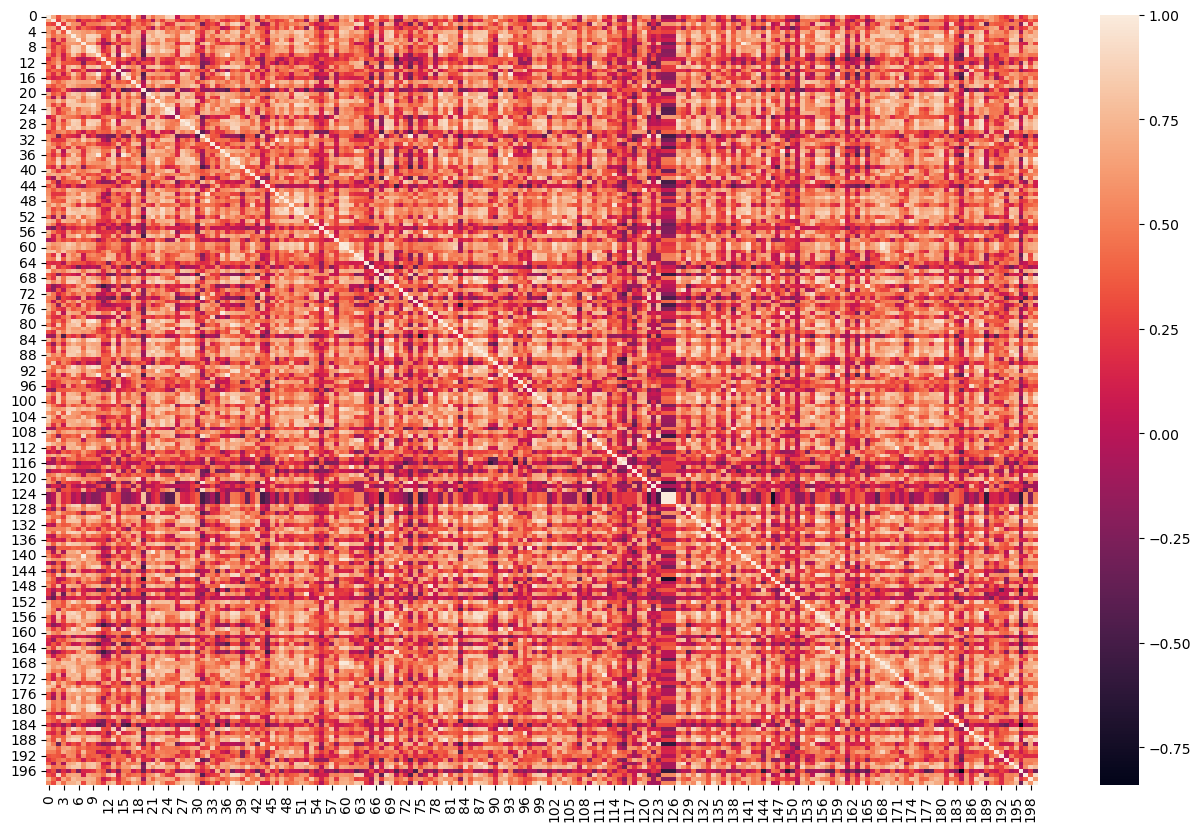

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from ast import literal_eval
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import warnings
warnings.filterwarnings("ignore")
from sklearn.decomposition import TruncatedSVD
from scipy.sparse.linalg import svds

# reading csv file created and exception handling
try:
    df = pd.read_csv('final_ITEM_DATA1.csv')
    df = df.dropna(subset=['Name'])
    df = df.dropna(subset=['AppID'])
    
    data = pd.read_csv('user_data.csv')
    new_column_names = {'gameName':'Name'}
    data.rename(columns=new_column_names, inplace=True)
    
    print("===================== item data Dataset ===================== ")
    print(df)
    
    print("===================== user data Dataset ===================== ")
    print(data)
    
    

    item_row = df[df['AppID'] == 1139950]
    
    # Print the rows for APPID 1139950
    print("========================== APPID 139950 ========================== ")
    print(item_row)

except FileNotFoundError as e:
    print("Error: Cannot find the File(CSV), Check the Path again")
    exit(1)
    
print("===================== data frame shape ===================== ")   
print("game data shape:")
print(df.shape)
print("user data shape:")
print(data.shape)

# Item data and game data are combined using a merge function.
user_item_data = pd.merge(data, df, on = 'Name')

# Create a pivot table and put a value at the beginning, 
# and put the game name in the column and the userid in the index.

# We set it as 'Publishers' as an example of value.
user_item_Publishers = user_item_data.pivot_table('Publishers', index = 'userId', columns='Name').fillna(0)

item_user_Publishers = user_item_Publishers.values.T

type(item_user_Publishers)

# Specific value decomposition SVD is used to decompose the data.
# ttruncated SVD is the selection of the top n diagonal elements of the sigma matrix.

# 1Dimension down to 12 components
SVD = TruncatedSVD(n_components=12)
matrix = SVD.fit_transform(item_user_Publishers)

print(matrix[0])

# Find Pearson correlation coefficients
corr = np.corrcoef(matrix)

corr2 = corr[:200, :200]

# Display as a heat map
plt.figure(figsize=(16, 10))
sns.heatmap(corr2)

# Recommend a movie with a high correlation coefficient with a particular movie
item_title = user_item_Publishers.columns
item_title_list = list(item_title)
coffey_hands = item_title_list.index("Fallout 4")

# Indicates a game with a high correlation coefficient with a particular game.
corr_coffey_hands  = corr[coffey_hands]
list(item_title[(corr_coffey_hands >= 0.9)])[:50]


In [33]:
def evaluate_recommender_recall_f1(user_item_matrix, original_ratings, top_n=10, threshold=0.9):
    """
    Evaluate the recommender system using recall and F1-score.

    Parameters:
    - user_item_matrix (numpy.ndarray): The user-item matrix after applying SVD.
    - original_ratings (pd.DataFrame): The original user-item matrix.
    - top_n (int): The number of top items to consider for evaluation.
    - threshold (float): The correlation coefficient threshold for considering a recommendation.

    Returns:
    - recall (float): Recall value.
    - f1_score (float): F1-score value.
    """
    num_users, num_items = user_item_matrix.shape
    true_positive = 0  # Number of correctly recommended items that the user likes
    all_recommended = 0  # Number of items recommended by the system
    actual_liked = 0  # Number of items that the user actually likes

    for user_index in range(num_users):
        # Get the indices of the top-n items recommended by the system
        top_n_indices = np.argsort(user_item_matrix[user_index, :])[-top_n:]

        # Get the items the user has actually interacted with
        actual_items = original_ratings.iloc[user_index, :].values.nonzero()[0]

        # Calculate the number of correctly recommended items
        correct_recommendations = np.intersect1d(top_n_indices, actual_items)
        true_positive += len(correct_recommendations)

        # Update the number of all recommended items
        all_recommended += len(top_n_indices)

        # Update the number of items that the user actually likes
        actual_liked += len(actual_items)

    # Calculate recall
    recall = true_positive / actual_liked if actual_liked > 0 else 0.0

    # Calculate precision
    precision = true_positive / all_recommended if all_recommended > 0 else 0.0

    # Calculate F1-score
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0.0

    return recall, f1_score

# Example usage:
recall, f1_score = evaluate_recommender_recall_f1(matrix, user_item_Release_date)
print(f'Recall: {recall}, F1-score: {f1_score}')

Recall: 0.0010620353595302055, F1-score: 0.0010107916877248268
